In [114]:
import matplotlib.pyplot as plt
from IPython.display import display, Math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib nbagg
# %matplotlib qt
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import cv2
import os
import math
import random
import pandas as pd

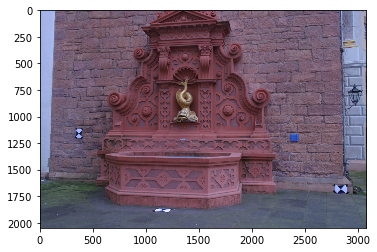

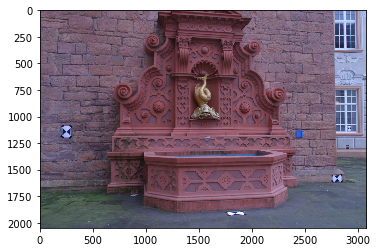

In [2]:
def image1():
    return plt.imread("CVassignment4_files/fountain1.jpg")
def image2():
    return plt.imread("CVassignment4_files/fountain2.jpg")
def image1_grey():
    gray = cv2.cvtColor(image1(), cv2.COLOR_BGR2GRAY)
    return np.dstack([gray, gray, gray])
def k1():
    k = pd.read_csv("CVassignment4_files/K1.txt", sep="\s+", header=None)
    k = np.asarray(k)
    return k
def k2():
    k = pd.read_csv("CVassignment4_files/K2.txt", sep="\s+", header=None)
    k = np.asarray(k)
    return k
def matches():
    matches = pd.read_csv("CVassignment4_files/matches.txt", sep="\s+", header=None)
    matches = np.asarray(matches, dtype=int)
    return matches
colour = (0,200,10)
start_col = (0,0,255)
end_col = (255,0,0)
thresh = 600

plt.imshow(image1())
plt.show()
plt.imshow(image2())
plt.show()


# Question 1
## 1a

In [3]:
def draw_matches(image, matches):
    for m in matches:
        cv2.circle(image,(m[0],m[1]), 50, start_col, thickness=1, lineType=8, shift=0)
        cv2.circle(image,(m[2],m[3]), 50, end_col, thickness=1, lineType=8, shift=0)
        cv2.line(image, (m[0],m[1]), (m[2],m[3]), colour, thickness=10, lineType=8)
    plt.imshow(image,cmap='gray')
    plt.show()

def get_good_matches(matches, threshold):
    end_points = matches[:, 2:4]
    start_points = matches[:, 0:2]
    good_matches = []
    for i in range(len(matches)):
        start = start_points[i]
        end = end_points[i]
        distance = math.sqrt((start[0]-end[0])**2 + (start[1]-end[1])**2)
        if distance < threshold:
            good_matches.append(matches[i])
    return np.asarray(good_matches)

def get_F(matches):
    X = matches[:, 2:4]
    x = matches[:, :2]
    
    A = []
    for i in range(0, len(x)):
        x1 = x[i][0] 
        y1 = x[i][1]
        X1 = X[i][0]
        Y1 = X[i][1]
        A.append([x1*X1, y1*X1, X1, x1*Y1,y1*Y1, Y1, x1, y1, 1])
        
    _,_,V = np.linalg.svd(A)
    f =V.T[:,V.shape[1] - 1]
    F_1 = np.array([
        [f[0],f[1],f[2]],
        [f[3],f[4],f[5]],
        [f[6],f[7],f[8]],
    ])
    U, S, V = np.linalg.svd(F_1)
    F = U.dot(np.diag(S).dot(V))
    return F

def get_F_RANSAC(matches):
    F = np.array([])
    inliers =[]
    for i in range(0, 10000000):
        r1 = random.randrange(0, len(matches), 1)
        r2 = random.randrange(0, len(matches), 1)
        r3 = random.randrange(0, len(matches), 1)
        r4 = random.randrange(0, len(matches), 1)
        r5 = random.randrange(0, len(matches), 1)
        r6 = random.randrange(0, len(matches), 1)
        r7 = random.randrange(0, len(matches), 1)
        r8 = random.randrange(0, len(matches), 1)
        ran_matches = np.array([
            matches[r1],
            matches[r2],
            matches[r3],
            matches[r4],
            matches[r5],
            matches[r6],
            matches[r7],
            matches[r8],
        ])
        temp_F = get_F(ran_matches)
        temp_inliers = []
        for match in matches:
            X = match[2:4]
            X = np.array([X[0], X[1], 1])
            x = match[:2] 
            x = np.array([x[0], x[1], 1])
            sd = X.dot(temp_F.dot(x))
            sd = sd**2
            sd = sd/((temp_F.dot(x)[0])**2 + (temp_F.dot(x)[1])**2 + (temp_F.T.dot(X)[0])**2 + (temp_F.T.dot(X)[1])**2)
            if sd < 10:
                temp_inliers.append(match)
        if len(temp_inliers) > len(inliers):
            inliers = temp_inliers
        inliers = np.asarray(inliers)
        return get_F(inliers), inliers

Image 1 Point is blue, Image 2 point is red
All Matches:


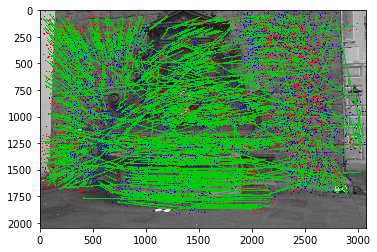

Good Matches: Threshold =  600


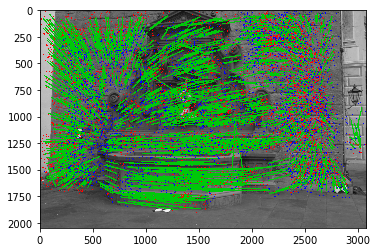

In [4]:
good_matches = get_good_matches(matches(), thresh)
print("Image 1 Point is blue, Image 2 point is red")
print("All Matches:")
draw_matches(image1_grey(), matches())
print("Good Matches: Threshold = ", thresh)
draw_matches(image1_grey(), get_good_matches(matches(), thresh))

It is better to use a leniancy threshold here, because the rest of the pipeline will be aimed at gathering inliers to exclude outliers and a high leniancy threshold will allow us to keep more inliers at the expense of a few more outliers that should be dealt with in the RANSAC phase.

## 1b

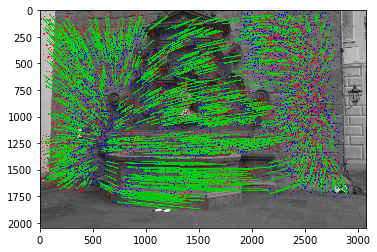

In [16]:
sgood_matches = get_good_matches(matches(), thresh)
F_R, RANSAC_matches = get_F_RANSAC(good_matches)
draw_matches(image1_grey(), RANSAC_matches)

In [17]:
print(F_R.tolist())

[[-6.529987852858793e-09, 1.0954541796091989e-07, -0.00016317418576772865], [3.506673930861817e-07, 1.8404719100252184e-08, 0.002781430915971061], [-0.00031756853925560426, -0.003643755081775867, 0.9999894295517512]]


## 1c

In [18]:
def get_E(K, K_1, F):
    return K_1.T.dot(F).dot(K)

def fix_SVD(E):
    U, S, V = np.linalg.svd(E)
    if np.linalg.det(U) > 0 and np.linalg.det(V.T) < 0:
        E = -E
        V= -V
    elif np.linalg.det(U) < 0 and np.linalg.det(V.T) > 0:
        E = -E
        U = -U
    return U, S, V, U.dot(np.diag(S)).dot(V)

E = get_E(k1(), k2(), F_R)
U, S, V_T, svd_E = fix_SVD(E)
print("E after svd fix:\n{}".format(svd_E))
print("U =\n{}".format(U))
print("S =\n{}".format(S))
print("V =\n{}".format(V_T.T))


E after svd fix:
[[-0.04972411  0.83557522 -0.17333024]
 [ 2.67476492  0.14062345  9.21354365]
 [ 0.07052249 -9.56025759  0.10888387]]
U =
[[-0.0755792   0.04712067  0.99602582]
 [-0.35171272 -0.93594271  0.01758999]
 [ 0.93305195 -0.34898551  0.08731075]]
S =
[9.59800732e+00 9.59624019e+00 3.83198246e-03]
V =
[[-0.09076776 -0.26368463  0.96032892]
 [-0.94111495  0.33806456  0.00387319]
 [-0.32567447 -0.90342834 -0.27884291]]


## 1d


In [19]:
def decomposeP(P):
    # The input P is assumed to be a 3−by−4 homogeneous camera matrix.
    # The function returns a homogeneous 3−by−3 calibration matrix K,
    # a 3−by−3 rotation matrix R and a 3−by−1 vector c such that
    # K*R*[eye(3), −c] = P.
    W = np.array([[0,0,1],
                  [0,1,0],
                  [1,0,0]])
    # calculate K and R (up to sign)
    t = np.matmul(W, P[:,0:3])
    Qt,Rt = np.linalg.qr(t.T)
    K = np.matmul(W,np.matmul(Rt.T,W))
    R = np.matmul(W,Qt.T)

    # correct for negative focal length(s) if necessary
    D = np.array([[1,0,0],
                  [0,1,0],
                  [0,0,1]])    
    if K[0,0] < 0:
        D[0,0] = -1
    if K[1,1] < 0: 
        D[1,1] = -1
    if K[2,2] < 0:
        D[2,2] = -1
    K = np.matmul(K,D)
    R = np.matmul(D,R)

    # calculate c
    c = -1*np.dot(R.T, np.dot(np.linalg.inv(K), P[:,3]))
    return K,R,c

def calc_X(p1,p2,match):

    Xend = []
    Ad =[]
    Ad = np.array([match[1] * p1[2].T - p1[1].T, 
    p1[0].T - match[0] * p1[2].T,
    match[3] * p2[2].T - p2[1].T,
    p2[0].T-match[2]*p2[2].T])

    Ud , sd, Vd = np.linalg.svd(Ad)

    Vd= Vd.T
    X = Vd[:,3]
    X = X/X[3]
    X = np.delete(X,3)
    return X

def triangulate_Ps(P1, P2_arr, match):
    p1 = P1
    p2 = P2[0]
    K1, R1, c1 = decomposeP(P1)
    KRc2 = [decomposeP(P) for P in P2_arr]
    
    x = match[0]
    y = match[1]
    x_1 = match[2]
    y_1 = match[3]
    
    for i in range(4):
        K2, R2, c2 = KRc2[i]
        p2 = P2_arr[i]
        X = calc_X(p1,p2, match)
        z1 = R1.T.dot(np.array([[0],[0],[1]]))
        z2 = R2.T.dot(np.array([[0],[0],[1]]))
        if z1.T.dot((X - c1)) > 0 and z2.T.dot((X - c2)) > 0:
            break
        
    return p1, p2
    

P1 = np.hstack((k1(), np.array([[0],[0],[0]])))
W = np.array([[0,-1,0],
             [1,0,0],
             [0,0,1]])
u3 = np.asarray(U[:,2])
u3 = np.array([[u3[0]],[u3[1]],[u3[2]]])

P2 = [
        k2().dot(np.hstack((U.dot(W).dot(V_T), u3))),
        k2().dot(np.hstack((U.dot(W).dot(V_T), -u3))),
        k2().dot(np.hstack((U.dot(W.T).dot(V_T), u3))),
        k2().dot(np.hstack((U.dot(W.T).dot(V_T), -u3)))
     ]
P1, P2 = triangulate_Ps(P1, P2, RANSAC_matches[0])
print("P1:")
print("{}".format(P1.tolist()))
print("P2:")
print("{}".format(P2.tolist()))

P1:
[[2759.481624939257, 0.0006033177578501637, 1520.694603991323, 0.0], [0.0, 2764.166687008687, 1006.812459789519, 0.0], [0.0, 0.0, 1.000000325363952, 0.0]]
P2:
[[3122.494187066776, -20.931134478051405, 420.5058785735263, 2881.2853051758634], [389.1828118692854, 2777.0353673487634, 889.2919711341352, 136.52673524333358], [0.3615551270786966, 0.013341851385728139, 0.9322552654741448, 0.0873107448090101]]


In [20]:
def get_3d_matches(p1, p2,matches):
    matches_3d = []
    for match in matches:
        matches_3d.append(calc_X(p1, p2, match))
    return np.asarray(matches_3d)

matches_3d = get_3d_matches(P1, P2, RANSAC_matches)

def rgb2hex(r,g,b):
    hex = "#{:02x}{:02x}{:02x}".format(r,g,b)
    return hex

def plot_3d(pts, matches, p1, p2):
    # Get Colours of pixels
    cols = []
    image = image1()
    for p in matches:
        colour = image[p[1]][p[0]]
        cols.append(rgb2hex(colour[0],colour[1],colour[2]))
    # Remove far away pixels
    pts_tmp = []
    cols_tmp = []
    for i in range(len(pts)):
        if pts[i][2] <2.7:
            pts_tmp.append(pts[i])
            cols_tmp.append(cols[i])
    pts = np.array(pts_tmp)
    cols = cols_tmp
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # Plot pixels    
    ax.scatter(pts[:,0],pts[:,1],pts[:,2], c=cols)
    
    # Plot cameras
    _, R1, c1 = decomposeP(p1)
    _, R2, c2 = decomposeP(p2)
    R1 = np.linalg.inv(R1)
    R2 = np.linalg.inv(R2)
    
    starts = np.array([[0,0,0],[0,0,0],[0,0,0]])
    ends = np.array([[0.5,0,0], [0,0.5,0], [0,0,0.5]])
    ax.scatter(c1[0],c1[1],c1[2], color='m', label="Camera 1")
    ax.scatter(c2[0],c2[1],c2[2], color='c', label="Camera 2")
    starts_1 = [np.matmul(R1,x)+c1 for x in starts]
    ends_1 = [np.matmul(R1, x) + c1 for x in ends]
    starts_x = [x[0] for x in starts_1]
    starts_y = [x[1] for x in starts_1]
    starts_z = [x[2] for x in starts_1]
    ends_x = [x[0] for x in ends_1]
    ends_y = [x[1] for x in ends_1]
    ends_z = [x[2] for x in ends_1]
    
    ax.plot([starts_x[0], ends_x[0]], [starts_y[0],ends_y[0]],zs=[starts_z[0],ends_z[0]], color='r', label="x1")
    ax.plot([starts_x[1], ends_x[1]], [starts_y[1],ends_y[1]],zs=[starts_z[1],ends_z[1]], color='g', label="y1")
    ax.plot([starts_x[2], ends_x[2]], [starts_y[2],ends_y[2]],zs=[starts_z[2],ends_z[2]], color='b', label="z1")
    
    starts_2 = [np.matmul(R2, x) + c2 for x in starts]
    ends_2 = [np.matmul(R2,x) + c2 for x in ends]
    
    starts_x = [x[0] for x in starts_2]
    starts_y = [x[1] for x in starts_2]
    starts_z = [x[2] for x in starts_2]
    ends_x = [x[0] for x in ends_2]
    ends_y = [x[1] for x in ends_2]
    ends_z = [x[2] for x in ends_2]
    ax.plot([starts_x[0], ends_x[0]], [starts_y[0],ends_y[0]],zs=[starts_z[0],ends_z[0]], color='r', label="x2")
    ax.plot([starts_x[1], ends_x[1]], [starts_y[1],ends_y[1]],zs=[starts_z[1],ends_z[1]], color='g', label="y2")
    ax.plot([starts_x[2], ends_x[2]], [starts_y[2],ends_y[2]],zs=[starts_z[2],ends_z[2]], color='b', label="z2")
    
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.autoscale(tight=True)
    ax.legend()
    plt.show()
    

In [21]:
%matplotlib qt
plot_3d(matches_3d, RANSAC_matches, P1, P2)

In [22]:
%matplotlib inline

# Question 2
## 2a

In [23]:
def apply_homography(a, h):
    """
    Image a having h applied to it
    """
    r, c, col = np.shape(a)
    # Determine size of output image by forward-transforming the four corners of A
    p1_h, p2_h, p3_h, p4_h = np.array([[0], [0], [1]], dtype=np.float), \
                             np.array([[c - 1], [0], [1]], dtype=np.float), \
                             np.array([[0], [r - 1], [1]], dtype=np.float), \
                             np.array([[c - 1], [r - 1], [1]], dtype=np.float)

    # Apply homography on each point
    p1, p2, p3, p4 = np.dot(h, p1_h), np.dot(h, p2_h), np.dot(h, p3_h), np.dot(h, p4_h)
    p1, p2, p3, p4 = p1 / p1[2, 0], p2 / p2[2, 0], p3 / p3[2, 0], p4 / p4[2, 0]

    # Get new min and max from each axis
    min_x = floor(min([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    max_x = ceil(max([p1[0, 0], p2[0, 0], p3[0, 0], p4[0, 0]]))
    min_y = floor(min([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))
    max_y = ceil(max([p1[1, 0], p2[1, 0], p3[1, 0], p4[1, 0]]))

    # Obtain new row and column
    nr, nc = max_y - min_y + 1, max_x - min_x + 1
    b = np.zeros([int(nr), int(nc), int(col)]) + 255
    h_inv = np.linalg.inv(h)
    for y in range(int(nr)):
        for x in range(int(nc)):
            p = np.array([[x + min_x], [y + min_y], [1]])
            pp = np.dot(h_inv, p)

            xp, yp = pp[0, 0] / pp[2, 0], pp[1, 0] / pp[2, 0]

            xpf, ypf = int(floor(xp)), int(floor(yp))
            xpc, ypc = xpf + 1, ypf + 1

            if (xpf >= 0) and (xpc < c) and (ypf >= 0) and (ypc < r):
                b[y, x, :] = ((xpc - xp) * (ypc - yp) * a[ypf, xpf, :]
                              + (xpc - xp) * (yp - ypf) * a[ypc, xpf, :]
                              + (xp - xpf) * (ypc - yp) * a[ypf, xpc, :]
                              + (xp - xpf) * (yp - ypf) * a[ypc, xpc, :])

    return min_x, min_y, max_x, max_y, b.astype(np.uint8)


def get_Kn(k1,k2):
    return 0.5*(k1 + k2)

def get_Homographies(p1,p2):
    K1, R1, c1 = decomposeP(p1)
    K2, R2, c2 = decomposeP(p2)
    Kn = get_Kn(K1,K2)
#     R1 = np.linalg.inv(R1)
#     R2 = np.linalg.inv(R2)
    k = R1.T.dot(np.array([0,0,1]))
    c = c2 - c1
    r1 = c/np.linalg.norm(c)
    kcross = np.cross(k, r1)
    r2 = kcross/np.linalg.norm(kcross)
    r3 = np.cross(r1, r2)
    Rn = np.array([r1,r2,r3])
    T1 = Kn.dot(Rn).dot(R1.T).dot(np.linalg.inv(K1))
    T2 = Kn.dot(Rn).dot(R2.T).dot(np.linalg.inv(K2))    
    return T1, T2


In [91]:
T1, T2 = get_Homographies(P1,P2)

In [136]:
# min_x1, min_y1, max_x1, max_y1,image1_rectified = apply_homography(image1(), T1)

In [135]:
# min_x2, min_y2, max_x2, max_y2,image2_rectified = apply_homography(image2(), T2)

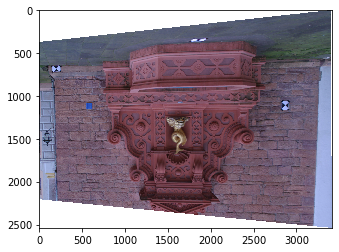

In [27]:
plt.imshow(image1_rectified)
plt.show()

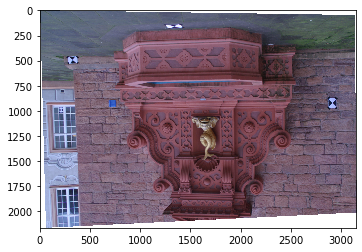

In [28]:
plt.imshow(image2_rectified)
plt.show()

## This Section has been saved to avoid heavy computation times

In [133]:
T1 = np.array([[-8.06665094e-01, -3.24781454e-03,  3.45979989e+03],
       [ 1.05776409e-01, -9.99580533e-01,  1.81241323e+03],
       [ 1.01048214e-04,  4.06834149e-07,  8.06263540e-01]])
T2 = np.array([[-1.04401448e+00, -2.49702084e-02,  2.88661266e+03],
       [-1.30424381e-02, -1.00466214e+00,  2.00138285e+03],
       [-3.15567883e-05, -4.87266479e-06,  1.04900445e+00]])
min_x2, min_y2, max_x2, max_y2 = (-394, -102, 2752, 2061)
min_x1, min_y1, max_x1, max_y1 = 873, -290, 4292, 2248

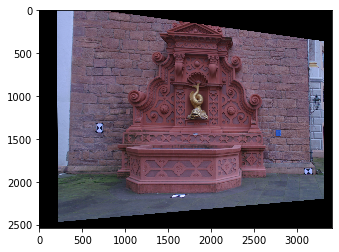

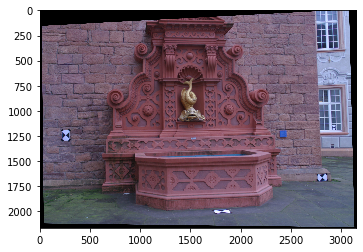

In [134]:

T1[0][2] = T1[0][2]  - min_x1
T1[1][2] = T1[1][2] - min_y1
T2[0][2] = T2[0][2]  - min_x2
T2[1][2] = T2[1][2] - min_y2
warped1 = cv2.warpPerspective(image1(), T1, (max_x1-min_x1, max_y1-min_y1))
warped1 = ndimage.rotate(warped1, 180)
plt.imshow(warped1)
plt.show()
warped2 = cv2.warpPerspective(image2(), T2, (max_x2-min_x2, max_y2-min_y2))
warped2 = ndimage.rotate(warped2, 180)
plt.imshow(warped2)
plt.show()